In [1]:
#from collections import defaultdict
#import numpy as np
import thinkstats2
import thinkplot
import random
#import pandas
import brfss
import math
import nsfg

# 06. 概率密度函数
本章代码位于`density.py`中。

## 6.1 PDF
CDF的导数称为`概率密度函数`（probability density function，PDF）。例如，指数分布的PDF公式如下：
+ $\displaystyle \rm PDF_{expo} = λe^{-λx}$

正态分布的PDF公式为：
+ $\displaystyle \rm PDF_{normal}(x) = \frac{1}{\sigma\sqrt {2\pi}}[-\frac{1}{2}(\frac{x- \mu}{\sigma})^2]$

对于特定值$x$，人们通常不会计算其PDF。计算PDF得到的不是概率，而是`概率密度`（density）。`概率密度`度量单位$x$的概率。为了计算概率，必须在$x$的取值范围上进行积分。

`thinkstats2`的概率密度函数类Pdf对象有如下方法：
+ **Density**: 参数为值$x$，返回当前分布在$x$上的密度
+ **Render**: 对一组离散值计算密度，返回一个数对序列，数对中包含值$xs$及其概率密度$ds$，序列按$xs$值排序
+ **MakePmf**: 对一组离散值计算Density，返回标准化的Pmf，结果近似Pdf
+ **GetLinspace**: 返回Render和MakePmf默认使用的点集

Pdf是一个抽象的父类，不能实例化。也就是说，你不能创建一个Pdf对象，而应该定义一个继承Pdf的子类，并提供`Density`和`GetLinspace`的定义。`thinkstats2`提供一个`NormalPdf`类，可用于计算正态密度函数：
```python
class NormalPdf(Pdf):
    def __init__(self, mu=0, sigma=1, label=''):
        self.mu = mu
        self.sigma = sigma
        self.label = label

    def Density(self, xs):
        return scipy.stats.norm.pdf(xs, self.mu, self.sigma)

    def GetLinspace(self):
        low, high = self.mu-3*self.sigma, self.mu+3*self.sigma
        return np.linspace(low, high, 101)
```

`NormalPdf`对象包含参数$\mu$和$\sigma$。`scipy.stats.norm`提供很多功能，包括`cdf`和`pdf`方法（参见`5.2节`）。

下面一段代码以BRFSS（参见`5.4节`）的成年女性身高的均值和方差为参数，创建一个NormalPdf对象，然后计算这个分布在距均值一个标准差处的密度：

In [2]:
mean, var = 163, 52.8
std = math.sqrt(var)
pdf = thinkstats2.NormalPdf(mean, std)
pdf.Density(mean + std)

0.033300124989618714

代码执行结果为0.03，单位为每厘米的概率值。需要再次声明，概率密度自身并没有太多含义。但是，如果绘制Pdf，我们就能看出这个分布的形状。：

0.033300124989618714


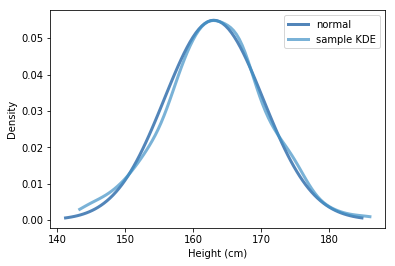

<Figure size 576x432 with 0 Axes>

In [3]:
def MakePdfExample(n=500):
    """Plots a normal density function and a KDE estimate.
    n: sample size
    """
    # mean and var of women's heights in cm, from the BRFSS
    mean, var = 163, 52.8
    std = math.sqrt(var)

    # make a PDF and compute a density, FWIW
    pdf = thinkstats2.NormalPdf(mean, std)
    print(pdf.Density(mean + std))

    # make a PMF and plot it
    thinkplot.PrePlot(2)
    thinkplot.Pdf(pdf, label='normal')

    # make a sample, make an estimated PDF, and plot it
    sample = [random.gauss(mean, std) for _ in range(n)]
    sample_pdf = thinkstats2.EstimatedPdf(sample)
    thinkplot.Pdf(sample_pdf, label='sample KDE')

    thinkplot.Show(root='pdf_example', xlabel='Height (cm)', ylabel='Density')

MakePdfExample()

`thinkplot.Pdf`绘制的Pdf是一个平滑函数，而`thinkplot.Pmf`绘制的Pmf是阶梯函数。上图展示了`thinkplot.Pdf`的绘制结果，以及从一个样本估计得到的PDF，下一节将讨论如何计算。

你可以使用MakePmf模拟Pdf。
```python
pmf = pdf.MakePmf()
```

默认情况下，MakePmf得到的Pmf对象包含101个点，均匀分布在从$\mu - 3*\sigma$到$\mu + 3*\sigma$的范围内。`MakePmf`和`Render`也可以使用关键字参数`low`、`high`以及点数`n`。

## 6.2 核密度估计
`核密度估计`（kernel density estimation，KDE）是一种算法，可以对一个样本寻找符合样本数据的适当平滑的PDF。你可以从[Wikipedia](http://en.wikipedia.org/wiki/Kernel_density_estimation)了解到更多的信息。

scipy提供了一种`KDE`实现，`thinkstats2`中的`EstimatedPdf`类使用了scipy的`KDE`实现：
```python
class EstimatedPdf(Pdf):

    def __init__(self, sample):
        self.kde = scipy.stats.gaussian_kde(sample)

    def Density(self, xs):
        return self.kde.evaluate(xs)
```

方法`__init__`以一个样本为参数，计算其核密度估计，得到一个`gaussian_kde`对象。

方法`Density`可以以值或序列为参数，调用`gaussian_kde.evaluate`方法，返回得到的密度。类`gaussian_kde`使用了一个基于高斯分布的过滤器，使KDE变得平滑，因此类名中用了Gaussian这个词。

下面一段代码展示了如何从一个正态分布生成一个样本，然后创建一个符合该样本的`EstimatedPdf`：

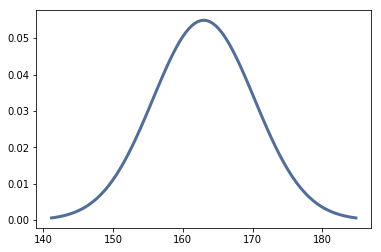

In [4]:
sample = [random.gauss(mean, std) for i in range(500)]
sample_pdf = thinkstats2.EstimatedPdf(sample)
thinkplot.Pdf(pdf, label='sample KDE')

`sample`是一个列表，包含`500`个随机身高。`sample_pdf`是一个Pdf对象，包含该样本的估计`KDE`。上图展示了正态密度函数，以及基于500个随机身高样本的KDE。估计结果与原始分布非常吻合。

KDE估计密度函数可用于如下用途：
+ 可视化：在项目的探索阶段，展现分布的最佳方法通常是CDF。在观察CDF之后，你可以判断估计PDF是否为该分布的适宜模型。如果PDF是适宜模型，那么就可以更好地向不熟悉CDF的受众展现这个分布
+ 插值：通过估计PDF，我们可以从样本得到总体模型。如果你相信总体分布是平滑的，那么就可以使用KDE为样本中不存在的值插入相应的密度
+ 模拟：模拟通常是基于一个样本分布。如果样本规模较小，那么我们或许可以使用KDE，对样本分布进行平滑处理，使得模拟可以探索可能性更高的结果，而不是复制所观察到的数据

## 6.3 分布框架
到目前为止，我们已经学习了PMF、CDF和PDF。下图展示了这些函数之间的关系：

<img src="images/06_02.png" style="width:600px;"/>

我们最先接触的是PMF。PMF代表一组离散值的概率。要从PMF得到CDF，需要把概率值累加得到累积概率。反过来，要从CDF得到PMF，需要计算累积概率之间的差值。我们将在接下来的几节讨论这些计算的具体实现。

PDF是连续型CDF的导数，或者说，CDF是PDF的积分。PDF将值映射到概率密度，要得到概率，必须进行积分运算。

要从离散型分布得到连续型分布，可以进行各种平滑处理。一种平滑处理方法是，假设数据来自一个连续的分析分布（如正态分布），然后估计这个分布的参数。另一种方法是核密度估计。

平滑处理的逆向操作是`离散化`（discretizing），或称为`量化`（quantizing）。如果在离散点上计算PDF，就可以生成近似这个PDF的PMF。使用数值积分可以获得更好的近似。

要明确区分连续型和离散型CDF，也许将离散型CDF称为`累积质量函数`（cumulative mass function）更合适，但据我所知没有人使用这个词。

## 6.4 Hist实现
接下来的几节将介绍`thinkstats2`包含的基本类型的具体实现。

`Hist`和`Pmf`继承了一个父类`_DictWrapper`(下划线表明这是一个内部类)。`_DictWrapper`的名字说明了这个类的功能，它是一个字典封装类，其主要属性是将值映射到相关频次的字典`d`。

`_DictWrapper`提供适用于`Hist`和`Pmf`的方法，包括`__init__`、`Values`、`Items`和`Render`。`_DictWrapper`还提供修饰符方法`Set`、`Incr`、`Mult`和`Remove`。示例如下：

```python
class_DictWrapper
    def Incr(self, x, term=1):
        self.d[x] = self.d.get(x, 0) + term

    def Mult(self, x, factor):
        self.d[x] = self.d.get(x, 0) * factor

    def Remove(self, x):
        del self.d[x]
```

`Hist`还提供方法`Freq`，用于查找一个给定值的频次。`Hist`的操作符和方法都是基于字典类的，因此这些方法都是常数时间操作，也就是说，这些方法的运行时间不会随着`Hist`对象变大而增加。

## 6.5 Pmf实现
`Pmf`和`Hist`基本类似，唯一的区别是`Pmf`将值映射到浮点数的概率值，而不是整数的频次。如果一个`Pmf`的概率总和为1，那么这个`Pmf`就是正态化的。

`Pmf`提供一个方法`Normalize`，这个方法计算所有概率的总和，并将所有概率除以一个因子：

````python
class Pmf
    def Normalize(self, fraction=1.0):
        total = self.Total()
        if total == 0.0:
            raise ValueError('Total probability is zero.')

        factor = float(fraction) / total
        for x in self.d:
            self.d[x] *= factor

        return total
```

参数`fraction`决定了正态化之后的概率总和，这个参数的默认值为1。如果`Pmf`中的概率总和为0，则无法进行正态化，因此这种情况下`Normalize`方法抛出一个`ValueError`。

如果实例化一个`Pmf`，得到的结果将是正态化的。如果实例化一个`Hist`，得到的结果不是正态化的。要构建一个非正态化的`Pmf`，可以先创建一个空的`Pmf`，然后进行修改。`Pmf`修饰符不会对`Pmf`重新进行正态化。

## 6.6 Cdf实现
CDF将值映射到累积概率，因此我原本可以用`_DictWrapper`实现Cdf。但是CDF中的值是按序排列的，而`_DictWrapper`中的值是乱序的。而且，人们经常需要计算CDF反函数，也就是说，从累积概率映射到值。因此，我选择使用两个排序列表来实现Cdf，以便使用二分法检索，在对数时间内进行正向或反向查找。

具体参考`thinkstats2`源码。

## 6.7 矩
不管在什么时候，只要将一个样本归结为一个数字，这个数字就是一个`统计量`。到目前为止，我们接触到的统计量包括`均值`、`方差`、`中位数`和`四分位距`等。

`原始矩`（raw moment）也是一个统计量。对于一组值为$x_i$的样本，第$k$个原始矩计算公式为：
+ $\displaystyle m^{'}_k=\frac{1}{n}\sum_{i}x^{k}_i$

Python实现如下：
```python
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)
```

当$k=1$时，原始矩为样本的均值$\hat{x}$。其余的原始矩本身并不具有任何意义，但可以用在一些计算中。

`中心矩`（central moment）的用途较多。第$k$个中心矩的计算公式为：
+ $\displaystyle m_k=\frac{1}{n}\sum_{i}(x_i-\bar x)^k$

Python实现如下：
```python
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)
```

当$k=2$时，计算结果是`第二中心矩`，其实就是`方差`。这些统计量为什么称为`矩`，`方差`的定义给了我们一些提示。如果我们在直尺的不同位置$x_i$附加一个重物，然后将直尺围绕这些值的均值旋转，旋转重物的`惯性力矩`（moment of inertia）就是这些值的方差。如果不熟悉惯性力矩的概念，可以参考[Wikipedia](http://en.wikipedia.org/wiki/Moment_of_inertia)。

在使用基于矩的统计量时，很重要的一点是考虑统计量的单位。例如，如果值$x_i$的单位是厘米，那么第一原始矩的单位也是厘米，但第二原始矩的单位是平方厘米，第三原始矩的单位是立方厘米，以此类推。

由于这些不同寻常的单位，矩本身的含义很难解释。正因为如此，人们通常会使用`标准差`而不是`第二中心矩`。`标准差`是`方差`的平方根，使用的单位与$x_i$相同。

## 6.8 偏度
`偏度`（skewness）是描述分布形状的一个属性。如果分布是以集中趋势为中心对称的，那么这个分布就`非偏斜的`（unskewed）。如果分布中的值向右延伸更多，那么这个分布就是`右偏`（right skewed）的；如果值向左延伸更多，那么这个分布就是`左偏`（left skewed）的。

`偏斜`（skewed）并不是通常所说`有偏`（biased）的含义。`偏度`只是描述了分布的形状，和采样过程是否有偏并无关系。

人们通常使用几个统计量对分布的偏度进行量化。对给定的值序列$x_i$，`样本偏度`（sample skewness）$g_1$的计算方法如下：
```python
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = math.sqrt(var)
    return CentralMoment(xs, k) / std**k

def Skewness(xs):
    return StandardizedMoment(xs, 3)
```

$g_1$是`第三标准化矩`（standardized moment），也就是说这个值经过了正态化，没有单位。

偏度为负值代表一个分布左偏，偏度为正值代表一个分布右偏。$g_1$的大小代表偏斜的程度，但是$g_1$的值本身很难解读。

在实际应用中，计算样本偏度通常并非好主意。分布中的任何离群值都会对$g_1$产生不同程度的影响。

衡量分布对称性的另一个方法是检查均值和中位数的关系。极端值对均值的影响比对中位数影响更大，因此在一个左偏分布中，均值会比中位数小；在右偏分布中，均值则比中位数大。

`Pearson中位数偏度系数`（Pearson's median skewness coefficient）是基于样本均值和中位数差的一种偏度度量：
+ $g_p=3(\bar x-m)/S$

其中$\bar x$是样本均值，$m$是中位数，$S$是标准差。Python实现如下：
```python
def Median(xs):
    cdf = thinkstats2.MakeCdfFromList(xs)
    return cdf.Value(0.5)

def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = math.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp
```

这个统计量是稳健的（robust），即受离群值的影响较小。

举个例子，让我们看看全国家庭增长调查妊娠数据中的新生儿体重的偏度：

Birth weight
mean 7.265628457623368
std 1.4082934455690173
median 7.375
skewness -0.5895062687577989
pearson skewness -0.23300028954731833


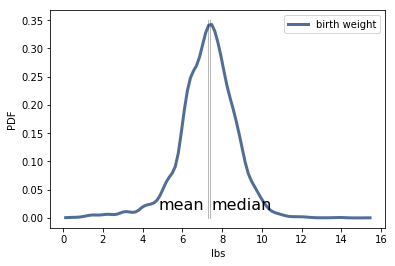

<Figure size 576x432 with 0 Axes>

In [5]:
def MakeFrames():
    preg = nsfg.ReadFemPreg(dct_file='datasets/2002FemPreg.dct',  dat_file='datasets/2002FemPreg.dat.gz')

    live = preg[preg.outcome == 1]
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    assert len(live) == 9148
    assert len(firsts) == 4413
    assert len(others) == 4735

    return live, firsts, others

def Summarize(data):
    mean = data.mean()
    std = data.std()
    median = thinkstats2.Median(data)
    print('mean', mean)
    print('std', std)
    print('median', median)
    print('skewness', thinkstats2.Skewness(data))
    print('pearson skewness', 
          thinkstats2.PearsonMedianSkewness(data))

    return mean, median

def ComputeSkewnesses():
    """Plots KDE of birthweight and adult weight.
    """
    def VertLine(x, y):
        thinkplot.Plot([x, x], [0, y], color='0.6', linewidth=1)

    live, firsts, others = MakeFrames()
    data = live.totalwgt_lb.dropna()
    print('Birth weight')
    mean, median = Summarize(data)

    y = 0.35
    VertLine(mean, y)
    thinkplot.Text(mean-0.15, 0.1*y, 'mean', horizontalalignment='right')
    VertLine(median, y)
    thinkplot.Text(median+0.1, 0.1*y, 'median', horizontalalignment='left')

    pdf = thinkstats2.EstimatedPdf(data)
    thinkplot.Pdf(pdf, label='birth weight')
    thinkplot.Show(root='density_totalwgt_kde',
                   xlabel='lbs',
                   ylabel='PDF')

ComputeSkewnesses()

上图展示了代码的运行结果。图中左尾看起来比右尾长，因此我们猜测这个分布是左偏的。其均值7.27磅比中位数7.38磅略小，与左偏分布的特征一致。样本偏度为-0.59，Pearson中位数偏度系数为-0.23，都是负值。

现在我们将这个分布与BRFSS成年人体重分布进行比较。估计和绘制BRFSS成年人体重PDF的代码如下：

Birth weight
mean 7.265628457623368
std 1.4082934455690173
median 7.375
skewness -0.5895062687577989
pearson skewness -0.23300028954731833
Adult weight
mean 78.9924529968581
std 19.546156913060994
median 77.27
skewness 1.054840012109306
pearson skewness 0.2643673381618039


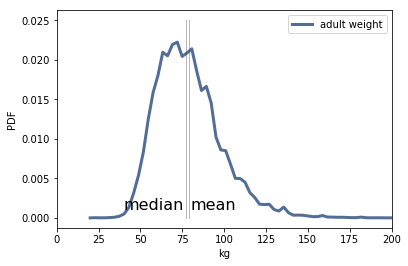

<Figure size 576x432 with 0 Axes>

In [6]:
def ComputeSkewnesses2():
    def VertLine(x, y):
        thinkplot.Plot([x, x], [0, y], color='0.6', linewidth=1)

    live, firsts, others = MakeFrames()
    data = live.totalwgt_lb.dropna()
    print('Birth weight')
    mean, median = Summarize(data)

    df = brfss.ReadBrfss("datasets/CDBRFS08.ASC.gz", nrows=None)
    data = df.wtkg2.dropna()
    print('Adult weight')
    mean, median = Summarize(data)

    y = 0.02499
    VertLine(mean, y)
    thinkplot.Text(mean+1, 0.1*y, 'mean', horizontalalignment='left')
    VertLine(median, y)
    thinkplot.Text(median-1.5, 0.1*y, 'median', horizontalalignment='right')

    pdf = thinkstats2.EstimatedPdf(data)
    thinkplot.Pdf(pdf, label='adult weight')
    thinkplot.Show(root='density_wtkg2_kde', xlabel='kg', ylabel='PDF', xlim=[0, 200])

ComputeSkewnesses2()

偏度系数为正或为负说明了分布左偏还是右偏，但除此之外，我们很难对偏度系数作出更多解释。样本偏度的稳健性较差，即更容易受到离群值的影响，因此在应用于偏斜分布时可靠性更低，而这恰恰是人们最关心样本偏度的时候。

Pearson中位数偏度系数基于计算所得的均值和方差，因此也会受到离群值影响，但这个系数不依赖第三矩，因此稳健性稍好一些。